In [2]:
pip install upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

# Model 
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [18]:
data = pd.read_csv('c:\\Users\\OMOLP028\\Downloads\\sound_dataset\\UrbanSound8K.csv')
audioPath = 'c:\\Users\\OMOLP028\\Downloads\\sound_dataset'
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


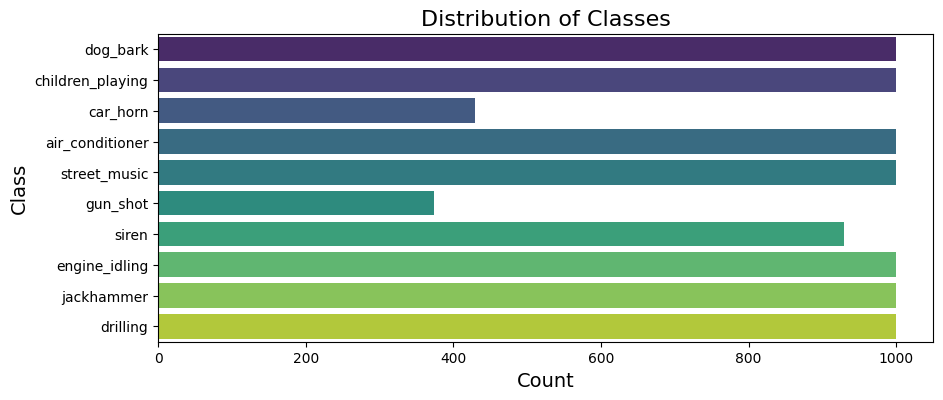

In [19]:
plt.figure(figsize = (10, 4))
sns.countplot(y = data['class'], palette = 'viridis')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

Class : car_horn



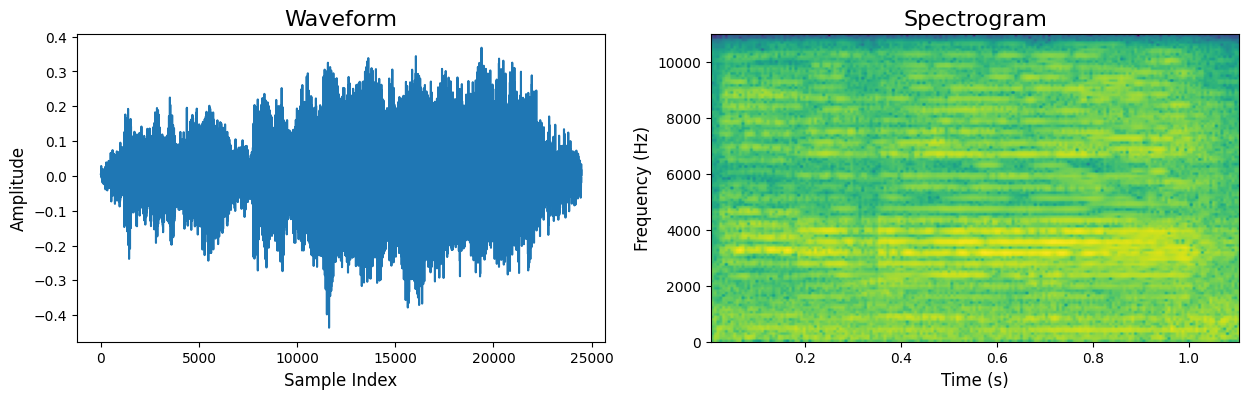

In [20]:
# Displaying a random waveform and spectrogram

# Randomly selecting a row
row = data.sample(1).iloc[0]

# Constructing file path
audioFile = os.path.join(audioPath, 'fold' + str(row['fold']), row['slice_file_name'])

# Loading audio file
waveform, sampleRate = librosa.load(audioFile)

# Displaying audio
print(f"Class : {row['class']}\n")
ipd.display(ipd.Audio(waveform, rate = sampleRate))

# Displaying waveform
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(waveform)
plt.title('Waveform', fontsize = 16)
plt.xlabel('Sample Index', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)

# Displaying spectrogram
plt.subplot(1, 2, 2)
plt.specgram(waveform, Fs = sampleRate)
plt.title('Spectrogram', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Frequency (Hz)', fontsize = 12)

plt.show()

In [21]:
def augmentData(waveform):
    # Applying pre-emphasis
    waveform = librosa.effects.preemphasis(waveform)
    
    # Time stretching
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.8, 1.2)
        waveform = librosa.effects.time_stretch(waveform, rate = rate)

    # Adding noise
    waveform += 0.01 * np.random.normal(size = waveform.shape)

    return waveform

In [22]:
def mfccExtract(file):
    # Loading audio file
    waveform, sampleRate = librosa.load(file)
    
    # waveform = augmentData(waveform)
    features = librosa.feature.mfcc(y = waveform, sr = sampleRate, n_mfcc = 64)
    return np.mean(features, axis = 1)

In [24]:
# Storing mfcc features along with classes in dataframe
extractAll = []

# Iterating through each row
for index, row in tqdm(data.iterrows()):
    # Constructing file path
    audioFile = os.path.join(audioPath, 'fold' + str(row['fold']), row['slice_file_name'])
    
    # Extracting features and appending them
    features = mfccExtract(audioFile)
    extractAll.append([features, row['class']])

8732it [03:17, 44.17it/s]


In [25]:
featuresDf = pd.DataFrame(extractAll, columns = ['Features', 'Class'])
featuresDf.head()

,Features,Class
0,"[-211.93698, 62.581207, -122.81315, -60.74528,...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing


In [26]:
# Converting features into numpy array
x = np.array(featuresDf['Features'].tolist())

# Encoding classes
encoder = LabelEncoder()
y = encoder.fit_transform(featuresDf['Class'])
y = to_categorical(y, num_classes = 10)

In [27]:
trainX, testX, trainY, testY = train_test_split(x, y, stratify = y, random_state = 0)

In [28]:
model = Sequential([
    layers.Dense(1024, activation = 'relu', input_shape = (64,)),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(32, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(10, activation = 'softmax')
])

# Defining optimizer, loss function, and metrics
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              66560     
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_2 (Bat  (None, 256)              

In [29]:
# Adding early stopping to avoid overfitting
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 5e-4,
    patience = 5,
    restore_best_weights = True
)

In [30]:
# Adding a learning rate annealer
reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-5
)

In [31]:
# Training model
history = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
    callbacks = [earlyStopping, reduceLR]
)

Epoch 1/50


205/205 [==============================] - 7s 13ms/step - loss: 1.4760 - accuracy: 0.5228 - val_loss: 1.1429 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 2/50
205/205 [==============================] - 2s 11ms/step - loss: 1.0075 - accuracy: 0.6775 - val_loss: 0.8865 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 3/50
205/205 [==============================] - 2s 12ms/step - loss: 0.7973 - accuracy: 0.7459 - val_loss: 0.7161 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 4/50
205/205 [==============================] - 2s 12ms/step - loss: 0.6777 - accuracy: 0.7865 - val_loss: 0.8051 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 5/50
205/205 [==============================] - 3s 13ms/step - loss: 0.5975 - accuracy: 0.8033 - val_loss: 0.5223 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 6/50
205/205 [==============================] - 2s 11ms/step - loss: 0.4957 - accuracy: 0.8409 - val_loss: 0.4868 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 7/50
205/205 [==============================] - 3s 14ms/

In [32]:
historyDf = pd.DataFrame(history.history)

<Axes: >

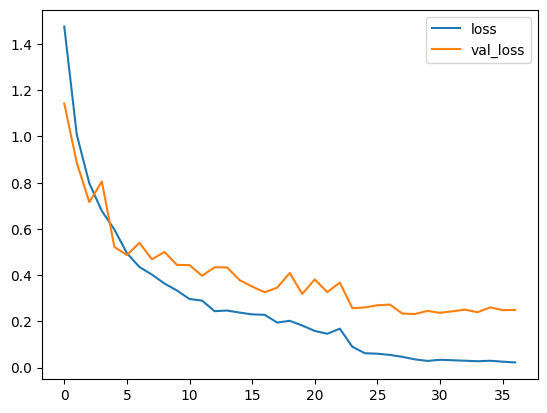

In [33]:
# Plotting training and validation loss
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

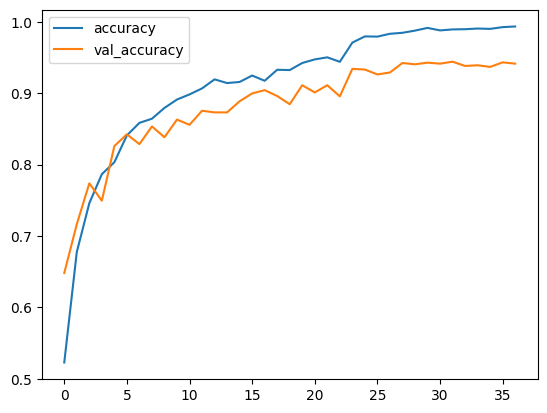

In [34]:
# Plotting training and validation accuracy
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

In [35]:
# Evaluating model
score = model.evaluate(testX, testY)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

69/69 [==============================] - 0s 3ms/step - loss: 0.2439 - accuracy: 0.9441
Validation accuracy of model : 94.41%


69/69 [==============================] - 1s 3ms/step


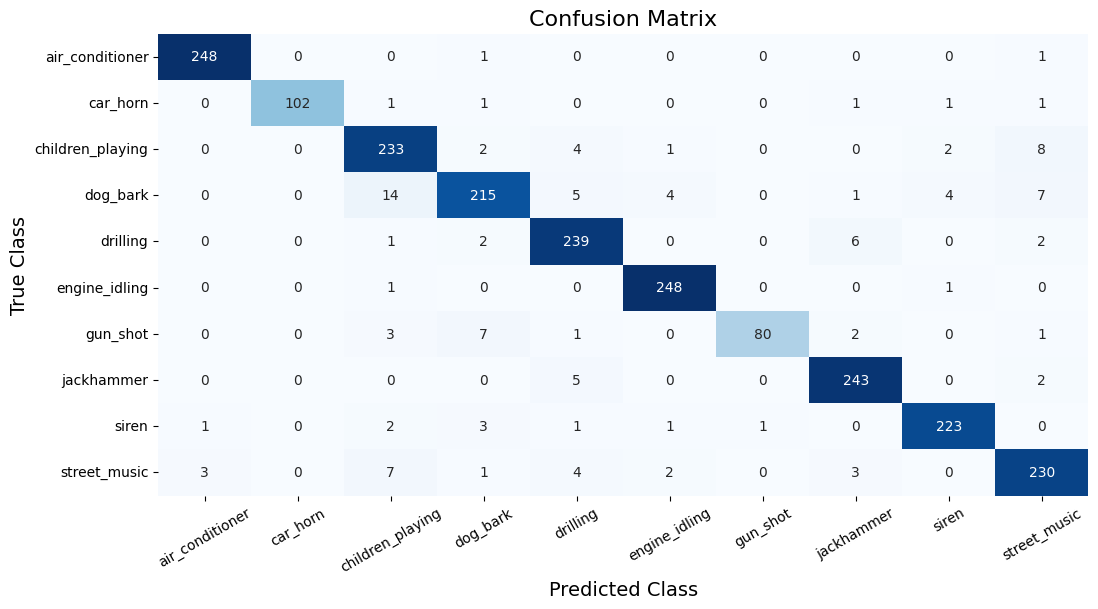

In [36]:
# Plotting confusion matrix
pred = np.argmax(model.predict(testX), axis = 1)
true = np.argmax(testY, axis = 1)

matrix = confusion_matrix(true, pred)

plt.figure(figsize = (12, 6))
sns.heatmap(matrix, annot = True, cbar = False, fmt = 'd', cmap = 'Blues', xticklabels = encoder.classes_, yticklabels = encoder.classes_)
plt.title('Confusion Matrix', fontsize = 16)
plt.xlabel('Predicted Class', fontsize = 14)
plt.xticks(rotation = 30)
plt.ylabel('True Class', fontsize = 14)
plt.show()